Process check....
Implementation of geometric_brownian OK!

........... Option Pricing Report ........................

Risk Neutral Pricing Method
Option type     : c
Option price    : 22.0939

Black-Scholes Pricing Method
Option type     : c
Option price    : 22.1546

Pricing error   : 0.0607
Percent error   : 0.27 %

..................................................


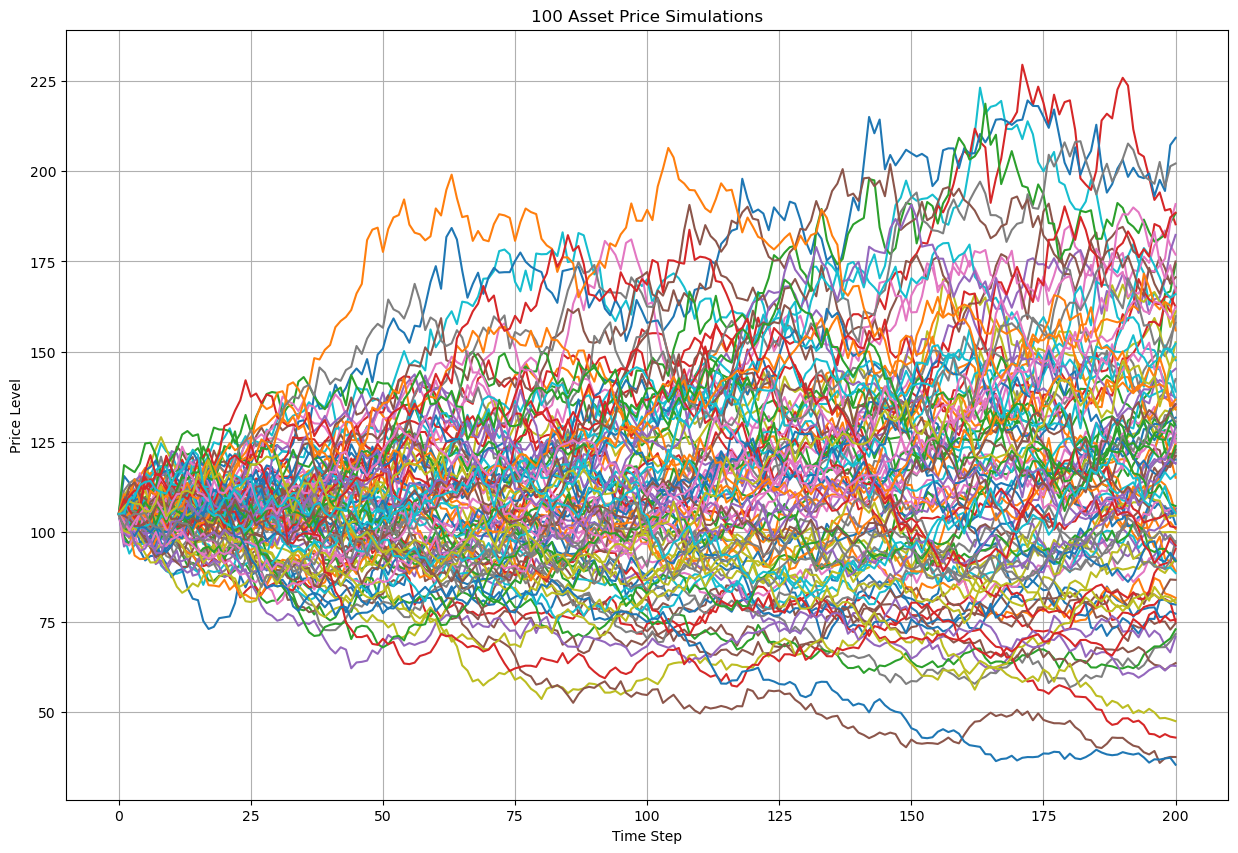

In [19]:
import numpy as np
from math import log, sqrt
from scipy.stats import norm
import matplotlib.pyplot as plt


# Helper class for managing parameters
class Parameters:
    ''' Class implementing a parameter object '''

    def __init__(self, S0, K, T, r, sigma, steps, sim, op_type):
        if op_type not in ("c", "p"):
            raise ValueError(
                "{} is not a valid option type, should be 'c' or 'p'.".format(op_type))

        self.S0 = S0        # Starting asset price
        self.K = K          # Option strike price
        self.T = T          # Time to maturity (years)
        self.r = r          # Risk-free interest rate
        self.sigma = sigma  # Asset volatility
        self.steps = steps  # Number of time steps
        self.sim = sim      # Number of simulations
        self.op_type = op_type  # Option type ("c" = call, "p" = put)


# Scenario generation engine
class ScenarioGenerationEngine(Parameters):
    ''' Class to implement scenario generation for stochastic processes '''

    def __init__(self, S0, K, T, r, sigma, steps, sim, op_type):
        super().__init__(S0, K, T, r, sigma, steps, sim, op_type)

    def geometric_brownian(self):
        ''' Simulate asset price paths using Geometric Brownian Motion '''
        dt = self.T / self.steps
        S = self.S0 * np.exp(np.cumsum((self.r - 0.5 * self.sigma ** 2) * dt + self.sigma *
                                       np.sqrt(dt) * np.random.standard_normal((self.steps + 1, self.sim)), axis=0))
        S[0] = self.S0
        return S


# Derivative Pricer
class DerivativePricer(ScenarioGenerationEngine):
    ''' Class implementing various methods of option pricing '''

    def __init__(self, S0, K, T, r, sigma, steps, sim, op_type):
        super().__init__(S0, K, T, r, sigma, steps, sim, op_type)

    def riskNeutral(self, s_prices):
        ''' Monte Carlo risk-neutral pricing method '''
        try:
            if self.op_type == "c":
                pay_off = np.maximum(s_prices[-1] - self.K, 0)
            else:
                pay_off = np.maximum(self.K - s_prices[-1], 0)
            return np.exp(-self.r * self.T) * np.mean(pay_off)
        except ArithmeticError:
            print("Input parameters not correct")

    def blackScholes(self):
        ''' Black-Scholes option pricing formula '''
        d1 = (log(self.S0 / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * sqrt(self.T))
        d2 = d1 - self.sigma * sqrt(self.T)

        try:
            if self.op_type == "c":
                return (self.S0 * norm.cdf(d1, 0.0, 1.0) - 
                        self.K * np.exp(-self.r * self.T) * norm.cdf(d2, 0.0, 1.0))
            else:
                return (self.K * np.exp(-self.r * self.T) * norm.cdf(-d2, 0.0, 1.0) -
                        self.S0 * norm.cdf(-d1, 0.0, 1.0))
        except ArithmeticError:
            print("Input parameters not correct")


# Helper functions
def price_path_plot(data, simulations):
    ''' Plot simulated asset paths '''
    plt.figure(figsize=(15, 10))
    plt.plot(data[:, :simulations])
    plt.grid(True)
    plt.title(f'{simulations} Asset Price Simulations')
    plt.xlabel('Time Step')
    plt.ylabel('Price Level')
    plt.show()


def price_hist(data):
    ''' Plot histogram of final asset prices '''
    plt.figure(figsize=(13, 7))
    plt.hist(data[-1], bins=70)
    plt.grid(True)
    plt.title('Asset Price Distribution')
    plt.xlabel('Asset Prices')
    plt.ylabel('Frequency')
    plt.show()


def check_class(_class, attribute):
    ''' Check if method is implemented in a class '''
    try:
        assert hasattr(_class, attribute)
        print('Process check....')
        print(f'Implementation of {attribute} OK!\n')
    except AssertionError:
        print('Process check....')
        print(f'{attribute} is not implemented in {_class}\n')


def pricer_report(S0, K, T, r, sigma, steps, sim, op_type):
    ''' Generate a pricing report '''
    pricer = DerivativePricer(S0, K, T, r, sigma, steps, sim, op_type)
    asset_prices = pricer.geometric_brownian()

    risk_neutral_price = round(pricer.riskNeutral(asset_prices), 4)
    black_scholes = round(pricer.blackScholes(), 4)
    pricing_error = round(black_scholes - risk_neutral_price, 10)
    percent_error = round((pricing_error / risk_neutral_price), 4) * 100

    print("........... Option Pricing Report ........................\n")
    print("Risk Neutral Pricing Method")
    print(f"Option type     : {pricer.op_type}")
    print(f"Option price    : {risk_neutral_price}")
    print("\nBlack-Scholes Pricing Method")
    print(f"Option type     : {pricer.op_type}")
    print(f"Option price    : {black_scholes}")
    print(f"\nPricing error   : {pricing_error}")
    print(f"Percent error   : {percent_error} %\n")
    print("..................................................")

    return [asset_prices, pricer]


# Main function
if __name__ == "__main__":
    check_class(ScenarioGenerationEngine, 'geometric_brownian')
    report = pricer_report(105.0, 100.0, 2, 0.05, 0.25, 200, 100000, "c")
    price_path_plot(report[0], 100)
